# DX 704 Week 3 Project

This week's project will give you practice with optimizing choices for bandit algorithms.
You will be given access to the bandit problem via a blackbox object, and you will investigate the bandit rewards to pick a suitable algorithm.

The full project description, a template notebook and supporting code are available on GitHub: [Project 3 Materials](https://github.com/bu-cds-dx704/dx704-project-03).


## Example Code

You may find it helpful to refer to these GitHub repositories of Jupyter notebooks for example code.

* https://github.com/bu-cds-omds/dx601-examples
* https://github.com/bu-cds-omds/dx602-examples
* https://github.com/bu-cds-omds/dx603-examples
* https://github.com/bu-cds-omds/dx704-examples

Any calculations demonstrated in code examples or videos may be found in these notebooks, and you are allowed to copy this example code in your homework answers.

## Part 1: Pick a Bandit Algorithm

Experiment with the multi-armed bandit interface using seed 0 to learn about the distribution of rewards and decide what kind of bandit algorithm will be appropriate.
A histogram will likely be helpful.

In [1]:
# DO NOT CHANGE

import numpy as np

class BanditProblem(object):
    def __init__(self, seed):
        self.seed = seed
        self.rng = np.random.default_rng(seed)

        self.num_arms = 3
        self.ns = self.rng.integers(low=1, high=10, size=self.num_arms)
        self.ps = self.rng.uniform(low=0.2, high=0.4, size=self.num_arms)

    def get_num_arms(self):
        return self.num_arms

    def get_reward(self, arm):
        if arm < 0 or arm >= self.num_arms:
            raise ValueError("Invalid arm")

        x = self.rng.uniform()
        x *= self.rng.binomial(self.ns[arm], self.ps[arm])

        return x


In [2]:
bandit0 = BanditProblem(0)

In [3]:
bandit0.get_num_arms()

3

In [4]:
bandit0.get_reward(arm=0)

1.8255111545554434

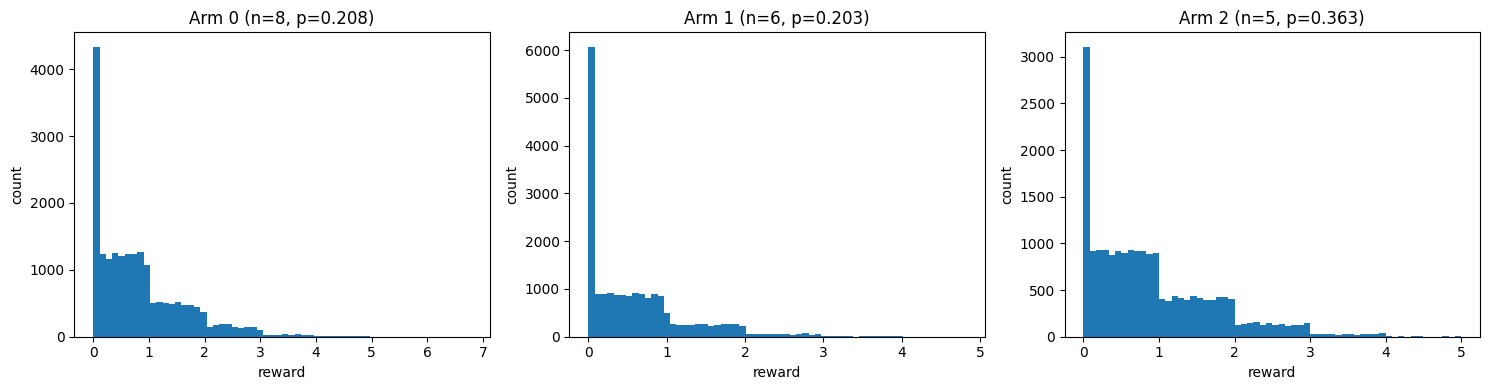

Arm 0: mean=0.8319, std=0.8188, P(reward=0)=0.1556
Arm 1: mean=0.6068, std=0.6742, P(reward=0)=0.2617
Arm 2: mean=0.9041, std=0.8199, P(reward=0)=0.1084


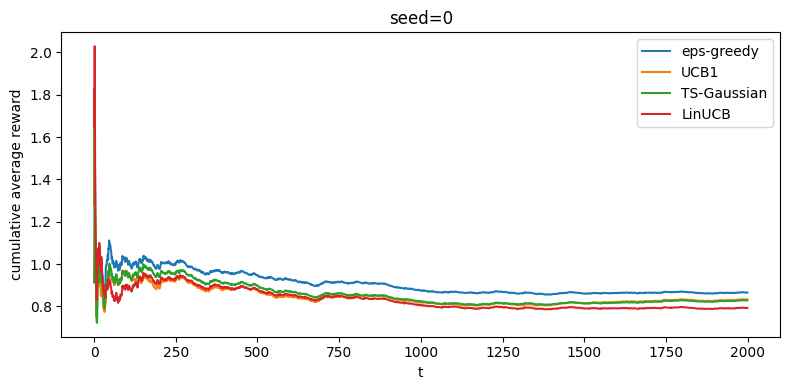

eps-greedy: total=1730.90, avg=0.8655
UCB1: total=1665.07, avg=0.8325
TS-Gaussian: total=1656.37, avg=0.8282
LinUCB: total=1584.93, avg=0.7925


In [5]:
import numpy as np
import matplotlib.pyplot as plt

def sample_histograms(seed=0, pulls_per_arm=20000, bins=60):
    b = BanditProblem(seed)
    K = b.get_num_arms()

    samples = []
    for a in range(K):
        rs = np.array([b.get_reward(a) for _ in range(pulls_per_arm)], dtype=float)
        samples.append(rs)

    plt.figure(figsize=(15, 4))
    for a in range(K):
        plt.subplot(1, K, a + 1)
        plt.hist(samples[a], bins=bins)
        plt.title(f"Arm {a} (n={b.ns[a]}, p={b.ps[a]:.3f})")
        plt.xlabel("reward")
        plt.ylabel("count")
    plt.tight_layout()
    plt.show()

    for a in range(K):
        rs = samples[a]
        print(f"Arm {a}: mean={rs.mean():.4f}, std={rs.std(ddof=1):.4f}, P(reward=0)={(rs==0).mean():.4f}")

def run_eps_greedy(seed=0, T=2000, eps=0.1):
    b = BanditProblem(seed)
    K = b.get_num_arms()
    rng = np.random.default_rng(123)

    counts = np.zeros(K)
    means = np.zeros(K)
    actions = np.zeros(T, dtype=int)
    rewards = np.zeros(T, dtype=float)

    t = 0
    for a in range(K):
        r = b.get_reward(a)
        actions[t], rewards[t] = a, r
        counts[a] = 1.0
        means[a] = r
        t += 1

    for t in range(t, T):
        if rng.uniform() < eps:
            a = int(rng.integers(0, K))
        else:
            a = int(np.argmax(means))

        r = b.get_reward(a)
        actions[t], rewards[t] = a, r
        counts[a] += 1.0
        means[a] += (r - means[a]) / counts[a]

    return actions, rewards

def run_ucb1(seed=0, T=2000):
    b = BanditProblem(seed)
    K = b.get_num_arms()

    counts = np.zeros(K)
    means = np.zeros(K)
    actions = np.zeros(T, dtype=int)
    rewards = np.zeros(T, dtype=float)

    t = 0
    for a in range(K):
        r = b.get_reward(a)
        actions[t], rewards[t] = a, r
        counts[a] = 1.0
        means[a] = r
        t += 1

    for t in range(t, T):
        ucb = means + np.sqrt(2.0 * np.log(t + 1.0) / counts)
        a = int(np.argmax(ucb))

        r = b.get_reward(a)
        actions[t], rewards[t] = a, r
        counts[a] += 1.0
        means[a] += (r - means[a]) / counts[a]

    return actions, rewards

def run_thompson_gaussian(seed=0, T=2000, rng_seed=999):
    b = BanditProblem(seed)
    K = b.get_num_arms()
    rng = np.random.default_rng(rng_seed)

    actions = np.zeros(T, dtype=int)
    rewards = np.zeros(T, dtype=float)

    m = np.zeros(K)
    kappa = np.ones(K) * 1e-3
    alpha = np.ones(K)
    beta = np.ones(K)

    def sample_mu(a):
        x = rng.gamma(shape=alpha[a], scale=1.0 / beta[a])
        sigma2 = 1.0 / x
        return rng.normal(loc=m[a], scale=np.sqrt(sigma2 / kappa[a]))

    for t in range(T):
        mu_samples = np.array([sample_mu(a) for a in range(K)])
        a = int(np.argmax(mu_samples))

        r = b.get_reward(a)
        actions[t], rewards[t] = a, r

        m0, k0, a0, b0 = m[a], kappa[a], alpha[a], beta[a]
        k1 = k0 + 1.0
        m1 = (k0 * m0 + r) / k1
        a1 = a0 + 0.5
        b1 = b0 + 0.5 * (k0 * (r - m0) ** 2) / k1
        m[a], kappa[a], alpha[a], beta[a] = m1, k1, a1, b1

    return actions, rewards

def run_linucb_contextual(seed=0, T=2000, alpha=1.0, lam=1.0):
    b = BanditProblem(seed)
    K = b.get_num_arms()
    d = K

    A = [lam * np.eye(d) for _ in range(K)]
    bvec = [np.zeros(d) for _ in range(K)]

    actions = np.zeros(T, dtype=int)
    rewards = np.zeros(T, dtype=float)

    def x_of(a):
        x = np.zeros(d)
        x[a] = 1.0
        return x

    for t in range(T):
        p = np.zeros(K)
        for a in range(K):
            Ainv = np.linalg.inv(A[a])
            theta = Ainv @ bvec[a]
            x = x_of(a)
            p[a] = theta @ x + alpha * np.sqrt(x @ Ainv @ x)

        a = int(np.argmax(p))
        r = b.get_reward(a)
        actions[t], rewards[t] = a, r

        x = x_of(a)
        A[a] += np.outer(x, x)
        bvec[a] += r * x

    return actions, rewards

def compare_part1(seed=0, T=2000):
    algs = {
        "eps-greedy": lambda: run_eps_greedy(seed, T, eps=0.1),
        "UCB1": lambda: run_ucb1(seed, T),
        "TS-Gaussian": lambda: run_thompson_gaussian(seed, T),
        "LinUCB": lambda: run_linucb_contextual(seed, T),
    }

    plt.figure(figsize=(8, 4))
    for name, fn in algs.items():
        _, r = fn()
        plt.plot(np.cumsum(r) / np.arange(1, T + 1), label=name)

    plt.xlabel("t")
    plt.ylabel("cumulative average reward")
    plt.title(f"seed={seed}")
    plt.legend()
    plt.tight_layout()
    plt.show()

    for name, fn in algs.items():
        _, r = fn()
        print(f"{name}: total={r.sum():.2f}, avg={r.mean():.4f}")

sample_histograms(seed=0)
compare_part1(seed=0)

Based on your investigation, pick an appropriate bandit algorithm to implement from the algorithms covered this week.
Write a file "algorithm-choice.txt" that states your choice and give a single sentence justifying your choice and rejecting the alternatives.
Keep your explanation concise; you should be able to justify your choice solely based on the type of numbers observed, and whether those match the bandit algorithms that you have learned.

In [6]:
with open("algorithm-choice.txt", "w", encoding="utf-8") as f:
    f.write(
        "UCB1\n"
        "Observed rewards are bounded, real-valued numbers (not just 0/1), so UCB1 matches this setting, while Bernoulli-based Thompson/Beta methods do not.\n"
    )


## Part 2: Implement Bandit

Based on your decision, implement an appropriate bandit algorithm and pick 1000 actions using seed 2026.

In [7]:
# YOUR CHANGES HERE

def ucb1_actions(bandit, T):
    K = bandit.get_num_arms()
    actions = np.zeros(T, dtype=int)
    rewards = np.zeros(T, dtype=float)

    counts = np.zeros(K)
    means = np.zeros(K)

    t = 0
    for a in range(K):
        r = bandit.get_reward(a)
        actions[t] = a
        rewards[t] = r
        counts[a] = 1.0
        means[a] = r
        t += 1

    for t in range(t, T):
        ucb = means + np.sqrt(2 * np.log(t + 1) / counts)
        a = int(np.argmax(ucb))
        r = bandit.get_reward(a)

        actions[t] = a
        rewards[t] = r
        counts[a] += 1
        means[a] += (r - means[a]) / counts[a]

    return actions, rewards


bandit = BanditProblem(seed=2026)
actions, rewards = ucb1_actions(bandit, 1000)




Write a file "history.tsv" with columns action and reward in the order that the actions were taken.

In [8]:
# YOUR CHANGES HERE
with open("history.tsv", "w") as f:
    f.write("action\treward\n")
    for a, r in zip(actions, rewards):
        f.write(f"{a}\t{r}\n")

Submit "history.tsv" in Gradescope.

## Part 3: Action Statistics

Based on the data from part 2, estimate the expected reward for each arm and write a file "actions.tsv" with the columns action, min_reward, mean_reward, max_reward.

In [9]:
# YOUR CHANGES HERE

K = int(actions.max()) + 1

with open("actions.tsv", "w") as f:
    f.write("action\tmin_reward\tmean_reward\tmax_reward\n")
    for a in range(K):
        r = rewards[actions == a]
        f.write(f"{a}\t{r.min()}\t{r.mean()}\t{r.max()}\n")


Submit "actions.tsv" in Gradescope.

## Part 4: Regret Estimates

Estimate the regret taking 1000 actions with the following strategies.

* uniform: Pick an arm uniformly at random.
* just-i: Always pick arm $i$. Do this for $i=0$ to $K-1$ where $K$ is the number of arms.
* actual: This should match your output in part 2.

These estimates should be based on your previous action statistics; you should not use the true action values from the bandit code.

In [10]:
# YOUR CHANGES HERE

T = 1000

data = np.loadtxt("actions.tsv", delimiter="\t", skiprows=1)
arms = data[:, 0].astype(int)
mean_rewards = data[:, 2]

K = len(mean_rewards)
best_mean = mean_rewards.max()

regrets = {}

regrets["uniform"] = T * best_mean - T * mean_rewards.mean()

for i in range(K):
    regrets[f"just-{i}"] = T * best_mean - T * mean_rewards[i]

actual_expected = 0.0
for i in range(K):
    actual_expected += np.sum(actions == i) * mean_rewards[i]

regrets["actual"] = T * best_mean - actual_expected



Write your results to a file "strategies.tsv" with the columns strategy and regret.

In [11]:
# YOUR CHANGES HERE


with open("strategies.tsv", "w") as f:
    f.write("strategy\tregret\n")
    for k, v in regrets.items():
        f.write(f"{k}\t{v}\n")



Submit "strategies.tsv" in Gradescope.

## Part 5: Acknowledgments

Make a file "acknowledgments.txt" documenting any outside sources or help on this project.
If you discussed this assignment with anyone, please acknowledge them here.
If you used any libraries not mentioned in this module's content, please list them with a brief explanation what you used them for.
If you used any generative AI tools, please add links to your transcripts below, and any other information that you feel is necessary to comply with the generative AI policy.
If no acknowledgements are appropriate, just write none in the file.


Submit "acknowledgments.txt" in Gradescope.

## Part 6: Code

Please submit a Jupyter notebook that can reproduce all your calculations and recreate the previously submitted files.

Submit "project.ipynb" in Gradescope.